In [3]:
#from sam2.sam2_image_predictor import SAM2ImagePredictor
#print(dir(sam2))
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
#from sam2.build_sam import build_sam2
#from sam2.sam2_image_predictor import SAM2ImagePredictor
import torchvision
print(f"{torch.__version__=}")
print(f"{torchvision.__version__=}")

from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from PIL import Image
from io import BytesIO
import sys
from config import topview_vec, sideview_vec, tcp_X_offset, tcp_Y_offset, tcp_Z_offset, n_depth_samples, arm_speed, vit_thresh
# sys.path.append("../")
import numpy as np
from magpie_control import realsense_wrapper as real
from magpie_control.ur5 import UR5_Interface as robot
from magpie_perception.label_owlv2 import LabelOWLv2

import pyrealsense2 as rs
import random
import time
import json
import warnings
import os
import cv2

from openai import OpenAI
import requests
import base64
import io
from APIKeys import API_KEY
from pydantic import BaseModel


/home/user/sam2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


torch.__version__='2.5.1+cu124'
torchvision.__version__='0.20.1'


2024-11-12 10:11:09.351702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 10:11:09.351758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 10:11:09.851244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 10:11:10.123534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 10:11:11.547960: W tensorflow/compiler/tf2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
myrs = real.RealSense()
myrs.initConnection()
myrobot = robot()
myrobot.start()
label_vit = LabelOWLv2(topk=1, score_threshold=vit_thresh, cpu_override=False)
label_vit.model.eval()
#print(dir(label_vit.model))
print(f"{label_vit.model.device=}")

sam_predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")
print(f"{sam_predictor.model.device=}")


Found Dynamixel Port:
/dev/ttyACM0

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
label_vit.model.device=device(type='cuda', index=0)
sam_predictor.model.device=device(type='cuda', index=0)


In [ ]:
myrobot.open_gripper()


Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [ ]:
def get_frames(rsWrapper):
    pipe, config = rsWrapper.pipe, rsWrapper.config
    frames = pipe.wait_for_frames()
    #alignOperator = rs.align(rs.stream.color)
    #alignOperator.process(frames)
    depthFrame = frames.get_depth_frame()  # pyrealsense2.depth_frame
    colorFrame = frames.get_color_frame()
    return colorFrame, depthFrame
def get_pictures(rsWrapper):
    colorFrame, depthFrame = get_frames(rsWrapper)
    #print(f"{type(starting_img)=}")
    #print(f"{dir(starting_img)=}")
    color_image = np.asarray(colorFrame.get_data())
    #color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
    depth_image = np.asarray(depthFrame.get_data())
    return color_image, depth_image

In [ ]:
def pose_vector_distance(goal_vec, actual_pose):
    """
    Check if two 6-degree pose vectors are equivalent within a specified tolerance.

    Parameters:
    - goal_vec: List of target pose [x, y, z, rx, ry, rz] in meters.
    - actual_pose: List of actual pose [x, y, z, rx, ry, rz] in meters.
    - tolerance_cm: Tolerance in centimeters (default is 0.01 meters).

    Returns:
    - True if the poses are equivalent within the tolerance, False otherwise.
    """


    # Calculate linear distance
    linear_distance = np.linalg.norm(np.array(goal_vec[:3]) - np.array(actual_pose[:3]))

    # Calculate angular differences (wrap around at 2*pi)
    angular_diffs = [
        np.arctan2(np.sin(goal_vec[i] - actual_pose[i]), np.cos(goal_vec[i] - actual_pose[i]))
        for i in range(3, 6)
    ]
    angular_distance = np.linalg.norm(angular_diffs)

    # Total distance check (considering both linear and angular)
    return linear_distance, angular_distance

def goto_vec(UR_interface, goal_vec, warning_tolorance=0.01, failure_tolerance=0.1):
    #print(f"{goal_vec=}")
    goal_matrix = UR_interface.poseVectorToMatrix(goal_vec)
    UR_interface.moveL(goal_matrix, linSpeed=arm_speed, asynch=False)
    actual_pose = UR_interface.recv.getActualTCPPose()
    #print(f"{actual_pose=}")
    linear_error, angular_error = pose_vector_distance(goal_vec, actual_pose)
    
    success = True
    if linear_error >= warning_tolorance:
        assert linear_error < failure_tolerance, f"Linear Error greater than failure tolerance {linear_error=} {goal_vec=} {actual_pose=}"
        warnings.warn(f"Linear Error greater than warning tolerance {linear_error=} {goal_vec=} {actual_pose=}")
        success = False
    if angular_error >= warning_tolorance:
        assert angular_error < failure_tolerance, f"Angular Error greater than failure tolerance {linear_error=} {goal_vec=} {actual_pose=}"
        warnings.warn(f"Angular Error greater than warning tolerance {angular_error=} {goal_vec=} {actual_pose=}")
        success = False
    return success


In [45]:
client = OpenAI(
    api_key= API_KEY,
)

#Function that takes a list of blocks in order of the tower [red, green, blue] and produces a prompt to be given to the GPT4o in sideview
#https://platform.openai.com/docs/guides/structured-outputs/examples
def get_state_querry_prompt():
    system_prompt = ("""
You are a block stacking robot.
You should output a json output with fields:
objects:list of objects in the scene relevant to the block stacking task. include the table as an object.
object_relationships: list of four touples of objects, where <OBJECT1, OBJECT2> means OBJECT1 is on top of OBJECT2. Include what objects are on the table in the object_relationships""")
    user_prompt = f"Give me the state in the given image"
    return system_prompt, user_prompt

def get_instruction_prompt(str_list_stack_order, state_obj):
    system_prompt = ("""
You are a block stacking planner.
You should output a json output with fields:
pick:str object to be picked up.
place:str object to place the pick object on top of.
Done:0/1 boolean for whether or not the tower is complete.
explanation:str why this a good move to get to our desired tower.
""")
    user_prompt = f"""Give me the next step so the blocks are stacked with the {str_list_stack_order[0]} on the table, the {str_list_stack_order[1]} on the {str_list_stack_order[0]}, and the {str_list_stack_order[2]} on the {str_list_stack_order[1]}. The objects are currently stacked as follows:\n"""
    for i in range(0,len(state_obj["object_relationships"])):
        user_prompt += f"""{state_obj["object_relationships"][i][0]} is on top of {state_obj["object_relationships"][i][1]}\n"""
    user_prompt += f""" we do not care about the state of other objects outside of the tower we are trying to stack. The tower may already be partially stacked, or even incorrectly stacked."""
    return system_prompt, user_prompt

#helper function that formats the image for GPT api
def encode_image(img_array):
    # Convert the ndarray to a PIL Image
    image = Image.fromarray(img_array)
    
    # Create a BytesIO object to save the image
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")  # Specify the format you want
    buffered.seek(0) #Possibly not needed
    # Get the byte data and encode to base64
    encoded_string = base64.b64encode(buffered.read()).decode('utf-8')
    
    return encoded_string

#api calling function
def get_gpt_next_instruction(rgb_image, desired_tower_order):
    image = encode_image(rgb_image)
    img_type = "image/jpeg"

    state_querry_system_prompt, state_querry_user_prompt = get_state_querry_prompt()
    print(f"{state_querry_system_prompt=}")
    print(f"{state_querry_user_prompt=}")
    state_response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            { "role": "system", "content": state_querry_system_prompt},  # Only text in the system message
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": state_querry_user_prompt},
                    {"type": "image_url", "image_url": {"url": f"data:{img_type};base64,{encode_image(rgb_image)}"}}
                ]
            },
        ],
        response_format={"type": "json_object"}
    )
    state_json = json.loads(state_response.choices[0].message.content)
    instruction_system_prompt, instruction_user_prompt = get_instruction_prompt(desired_tower_order, state_json)
    print(f"{instruction_system_prompt=}")
    print(f"{instruction_user_prompt=}")

    instruction_response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            { "role": "system", "content": instruction_system_prompt},  # Only text in the system message
            { "role": "user", "content": instruction_user_prompt}
        ],
        response_format={"type": "json_object"}
    )
    instruction_json = json.loads(instruction_response.choices[0].message.content)
    return (state_response, state_json), (instruction_response, instruction_json)

    




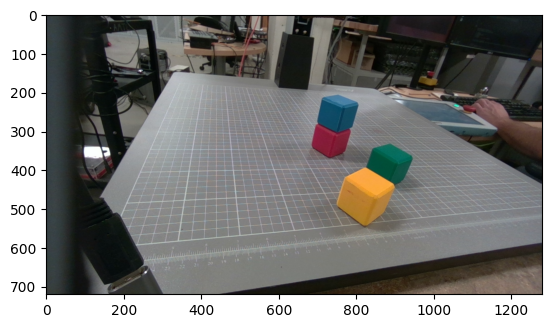

state_querry_system_prompt='\nYou are a block stacking robot.\nYou should output a json output with fields:\nobjects:list of objects in the scene relevant to the block stacking task. include the table as an object.\nobject_relationships: list of four touples of objects, where <OBJECT1, OBJECT2> means OBJECT1 is on top of OBJECT2. Include what objects are on the table in the object_relationships'
state_querry_user_prompt='Give me the state in the given image'
instruction_system_prompt='\nYou are a block stacking planner.\nYou should output a json output with fields:\npick:str object to be picked up.\nplace:str object to place the pick object on top of.\nDone:0/1 boolean for whether or not the tower is complete.\nexplanation:str why this a good move to get to our desired tower.\n'
instruction_user_prompt='Give me the next step so the blocks are stacked with the red block on the table, the blue block on the red block, and the yellow block on the blue block. The objects are currently stack

KeyError: 'next_step'

In [46]:

goto_vec(myrobot, sideview_vec)
rgb_img, depth_img = get_pictures(myrs)

plt.figure()
plt.imshow(rgb_img)
plt.show()
plt.imsave("./test_img.jpg", rgb_img)

##--string for GPT QUERY--##
(state_response, state_json), (instruction_response, instruction_json) = get_gpt_next_instruction(rgb_img, ["red block", "blue block", "yellow block"])


print()
print(f"{state_json['objects']=}")
print(f"{state_json['object_relationships']=}")

print(f"{instruction_json['pick']=}")

print(f"{instruction_json['place']=}")

print(f"{instruction_json['Done']=}")

print(f"{instruction_json['explanation']=}")
print(f"{instruction_json['next_step']=}")
print()
print(f"{state_response=}")
print(f"{instruction_response=}")
sys.exit()


In [ ]:
def get_depth_frame_intrinsics(rs_wrapper):
    rgb_frame, depth_frame = get_frames(rs_wrapper)
    intrinsics = depth_frame.profile.as_video_stream_profile().intrinsics
    return depth_frame, intrinsics

def get_topview_depth(point_list, UR_interface, rs_wrapper):

    goto_vec(UR_interface, topview_vec)
    depth_measurements = [[] for p in point_list]
    intrinsics = None
    for i in range(n_depth_samples):
        depth_frame, intrinsics = get_depth_frame_intrinsics(rs_wrapper)
        for i, (x, y) in enumerate(point_list):
            depth_val = depth_frame.get_distance(x, y)  # in meters
            if depth_val > 0:
                depth_measurements[i].append(depth_val)
    
    depth_measurements = [np.array(point_measurements) for point_measurements in depth_measurements]
    final_depth_measurements = [0 for point in point_list]
    for i, measurements in enumerate(depth_measurements):
        std = np.std(measurements)
        mean = np.mean(measurements)
        in_std_mask = np.abs(measurements-mean) <= std
        depth_measurements = measurements[in_std_mask]
        #print(f"{depth_measurements=}")
        depth_val = sum(measurements)/len(measurements)
        #print(f"{depth_val=}")
        assert depth_val > 0, f"not able to get depth val after {n_depth_samples} samples {depth_val=}"
        final_depth_measurements[i] = depth_val
    return final_depth_measurements

def deproject_top_view_point(K, pixel_x, pixel_y, depth):
    return rs.rs2_deproject_pixel_to_point(K, [pixel_x, pixel_y], depth)

In [ ]:
"""

pick_place_BB takes the color of the block that needs to be picked up and the color of the block 
to be placed on and gives the cords of where each are located as {xmin, ymin, xmax, ymax, strlabel}

"""
def get_bb_patch(bb, edge_color = "r"):
    rect = patches.Rectangle(
                            (bb["xmin"], bb["ymin"]),
                                bb["xmax"] - bb["xmin"],
                                bb["ymax"] - bb["ymin"],
                                linewidth=2, edgecolor=edge_color, facecolor='none'
                            )
    return rect

def topview_pick_place_BB(UR_Interface, rs_wrapper, pick_str, place_str, display= False):
    #print(place_str)
    #initlize local variables
    goto_vec(UR_Interface, topview_vec)
    rgb_img, depth_img = get_pictures(rs_wrapper)
    pick_cord_dict, place_cord_dict = {} , {}
    str_cords = ["xmin", "ymin", "xmax", "ymax"]
    queries = [pick_str, place_str]
    abbrevq = [pick_str, place_str]
    
    #pick bboxes and cords
    with torch.no_grad():
        pick_bbox = label_vit.label(rgb_img, queries[0], abbrevq[0], plot=False, topk=True)
        place_bbox = label_vit.label(rgb_img, queries[1], abbrevq[1], plot=False, topk=True)

    pick_bbox_cords = pick_bbox[1][0].tolist()
    for pick, cord in zip(pick_bbox_cords, str_cords):
        #print(f"{pick=}")
        pick_cord_dict[cord] = int(pick)
    
    #place bboxes and cords
    place_bbox_cords = place_bbox[1][0].tolist()
    for place , cord in zip(place_bbox_cords, str_cords):
        place_cord_dict[cord] = int(place)
    
    invalid_border_px_x = 200
    invalid_border_px_y = 20
    print(f"{rgb_img.shape=}")
    print(f"{place_cord_dict=}")

    for k in ["xmin", "xmax"]:
        pick_cord_dict[k] = np.clip(pick_cord_dict[k], 0+invalid_border_px_x, rgb_img.shape[1]-invalid_border_px_x)
        place_cord_dict[k] = np.clip(place_cord_dict[k], 0+invalid_border_px_x, rgb_img.shape[1]-invalid_border_px_x)
    for k in ["ymin", "ymax"]:
        pick_cord_dict[k] = np.clip(pick_cord_dict[k], 0+invalid_border_px_y, rgb_img.shape[0]-invalid_border_px_y)
        place_cord_dict[k] = np.clip(place_cord_dict[k], 0+invalid_border_px_y, rgb_img.shape[0]-invalid_border_px_y)
    print(f"{place_cord_dict=}")
    

    pick_cord_dict["strlabel"] = pick_str
    place_cord_dict["strlabel"] = place_str

    pick_cord_dict["xCenter"] = int((pick_cord_dict['xmin'] + pick_cord_dict["xmax"])/2)
    pick_cord_dict["yCenter"] = int((pick_cord_dict['ymin'] + pick_cord_dict["ymax"])/2)

    place_cord_dict["xCenter"] = int((place_cord_dict['xmin'] + place_cord_dict["xmax"])/2)
    place_cord_dict["yCenter"] = int((place_cord_dict['ymin'] + place_cord_dict["ymax"])/2)

    #print(f"{pick_cord_dict=}")
    #print(f"{place_cord_dict=}")

    if display:
        fig, axes = plt.subplots(nrows=2, ncols=2)
        axes[0, 0].imshow(rgb_img)
        axes[1, 0].imshow(depth_img)
        
        axes[0, 0].add_patch(get_bb_patch(pick_cord_dict, "r"))
        axes[1, 0].add_patch(get_bb_patch(pick_cord_dict, "r"))

        axes[0, 0].text(pick_cord_dict["xmin"], pick_cord_dict["ymin"] - 10, f"pick: {pick_cord_dict['strlabel']}", color='r', fontsize=12, ha='left', va='bottom')
        axes[1, 0].text(pick_cord_dict["xmin"], pick_cord_dict["ymin"] - 10, f"pick: {pick_cord_dict['strlabel']}", color='r', fontsize=12, ha='left', va='bottom')

        axes[0, 0].add_patch(get_bb_patch(place_cord_dict, "g"))
        axes[1, 0].add_patch(get_bb_patch(place_cord_dict, "g"))

        axes[0, 0].text(place_cord_dict["xmin"], place_cord_dict["ymin"] - 10, f"place {place_cord_dict['strlabel']}", color='g', fontsize=12, ha='left', va='bottom')
        axes[1, 0].text(place_cord_dict["xmin"], place_cord_dict["ymin"] - 10, f"place {place_cord_dict['strlabel']}", color='g', fontsize=12, ha='left', va='bottom')
        
        axes[0, 0].set_title("pick and place bb in rgb", fontsize=14)
        axes[1, 0].set_title("pick and place bb in depth", fontsize=14)

        sam_predictor.set_image(rgb_img)
        
        input_box = np.array([pick_cord_dict["xmin"],  pick_cord_dict["ymin"],  pick_cord_dict["xmax"],  pick_cord_dict["ymax"]])
        pick_mask, pick_scores, pick_logits = sam_predictor.predict(box=input_box)
        pick_mask = np.transpose(pick_mask, (1, 2, 0))
        axes[0, 1].set_title("pick segmentation", fontsize=14)
        axes[0, 1].imshow(pick_mask)

        input_box = np.array([place_cord_dict["xmin"],  place_cord_dict["ymin"],  place_cord_dict["xmax"],  place_cord_dict["ymax"]])
        place_mask, place_scores, place_logits = sam_predictor.predict(box=input_box)
        place_mask = np.transpose(place_mask, (1, 2, 0))
        axes[1, 1].set_title("place segmentation", fontsize=14)
        axes[1, 1].imshow(place_mask)

        plt.tight_layout()
        plt.show()

    _, K = get_depth_frame_intrinsics(rs_wrapper)
    depth_querry_list = [
        (pick_cord_dict["xCenter"], pick_cord_dict["yCenter"]),
        (pick_cord_dict['xmin'], pick_cord_dict['ymin']),
        (pick_cord_dict['xmax'], pick_cord_dict['ymin']),
        (place_cord_dict["xCenter"], place_cord_dict["yCenter"]),
        (place_cord_dict['xmin'], place_cord_dict['ymin']),
        (place_cord_dict['xmax'], place_cord_dict['ymin'])
    ]
    pick_c_d, pick_ll_d, pick_lr_d, place_c_d, place_ll_d, place_lr_d = get_topview_depth(depth_querry_list, UR_Interface, rs_wrapper)

    pick_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(K, pick_cord_dict["xCenter"], pick_cord_dict["yCenter"], pick_c_d)
    pick_LL_X, pick_LL_Y, pick_LL_Z = deproject_top_view_point(K, pick_cord_dict['xmin'], pick_cord_dict['ymin'], pick_ll_d)
    pick_LR_X, pick_LR_Y, pick_LR_Z = deproject_top_view_point(K, pick_cord_dict['xmax'], pick_cord_dict['ymin'], pick_lr_d)
    pick_sidelength =  (pick_LL_X-pick_LR_X)**2
    pick_sidelength += (pick_LL_Y-pick_LR_Y)**2
    pick_sidelength += (pick_LL_Z-pick_LR_Z)**2
    pick_sidelength = np.sqrt(pick_sidelength)
    pick_cord_dict["sidelength"] = pick_sidelength
    print(f"{pick_cord_dict=}")

    place_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(K, place_cord_dict["xCenter"], place_cord_dict["yCenter"], place_c_d)
    place_LL_X, place_LL_Y, place_LL_Z = deproject_top_view_point(K, place_cord_dict['xmin'], place_cord_dict['ymin'], place_ll_d)
    place_LR_X, place_LR_Y, place_LR_Z = deproject_top_view_point(K, place_cord_dict['xmax'], place_cord_dict['ymin'], place_lr_d)
    place_sidelength =  (place_LL_X-place_LR_X)**2
    place_sidelength += (place_LL_Y-place_LR_Y)**2
    place_sidelength += (place_LL_Z-place_LR_Z)**2
    place_sidelength = np.sqrt(place_sidelength)
    place_cord_dict["sidelength"] = place_sidelength
    print(f"{place_cord_dict=}")
    

    
    


    #return dictionarys with {xmin, ymin, xmax, ymax, strlabel}
    #return (pick_bbox, pick_cord_dict) , (place_bbox, place_cord_dict)
    return pick_cord_dict, place_cord_dict

   



In [ ]:
def pick(UR_interface, bb):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset - bb["sidelength"]
    
    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)
    #print(goal_vec)
    #UR_interface.disconnect()
    #input()

    UR_interface.close_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)
    return success

#pick(myrobot, myrs, pick_bb, display = True)

In [ ]:
def place(UR_interface, bb):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset

    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)


    UR_interface.open_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)

    return success
#place(myrobot, myrs, place_bb, display = True)

No LLM PLANNING

In [ ]:
"""
#myrobot.stop()
#myrs.disconnect()
#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]
tower = ["grey table", "yellow block", "blue block", "red block"]#, "green block"]
#tower = ["yellow block", "red block"]
for i in range(0, len(tower)-1):
     pick_str = tower[i+1]
     place_str = tower[i]
     pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)
     pick(myrobot, pick_bb)
     place(myrobot, place_bb)
"""

YES LLM PLANNING

In [ ]:
def create_next_directory(base_dir):
    # List all subdirectories in the base directory
    subdirectories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Extract the numeric part of the directory names (e.g., 'run_0', 'run_1')
    subdirectories = [d for d in subdirectories if d.startswith('run_')]
    subdirectories = [int(d.split('_')[1]) for d in subdirectories if d.split('_')[1].isdigit()]
    
    # If there are no subdirectories, start from 0, else find the max and add 1
    next_dir = max(subdirectories, default=-1) + 1

    # Create the new directory with the name 'run_<next_dir>'
    next_dir_path = os.path.join(base_dir, f"run_{next_dir}")
    os.makedirs(next_dir_path, exist_ok=True)
    
    return next_dir_path

In [ ]:

#tower = ["red block", "blue block", "green block", "yellow block", "purple block"]
tower = ["red block", "blue block", "yellow block"]
n_attempts = 2*len(tower)
Done = 0
i = 0
save_dir = create_next_directory("./data_collection/")

while(not Done and i < n_attempts):
    interation_output_dir = os.path.join(save_dir, f"step {i}")
    os.makedirs(interation_output_dir, exist_ok=True)
    goto_vec(myrobot, sideview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"side view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "sideview.png"), rgb_img)
    (state_resp, state), (instruction_resp, instruction) = get_gpt_next_instruction(rgb_img, tower)
    Done = int(instruction["Done"])
    
    with open(os.path.join(interation_output_dir, "instruction.txt"), "w") as file:
        print()
        print(f"{state['objects']=}")
        file.write(f"{state['objects']=}\n")

        print(f"{state['object_relationships']=}")
        file.write(f"{state['object_relationships']=}\n")

        print(f"{instruction['pick']=}")
        file.write(f"{instruction['pick']=}\n")

        print(f"{instruction['place']=}")
        file.write(f"{instruction['place']=}\n")

        print(f"{instruction['Done']=}")
        file.write(f"{instruction['Done']=}\n")

        print(f"{instruction['explanation']=}")
        file.write(f"{instruction['explanation']=}\n")

        print(f"{instruction['next_step']=}")
        file.write(f"{instruction['next_step']=}")

        print()
        file.write(f"{state_resp=}")
        file.write(f"{instruction_resp=}")

    if Done:
        break
    pick_str= instruction['pick']
    place_str= instruction['place']
    goto_vec(myrobot, topview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"top view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "topview.png"), rgb_img)
    pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, display=True)
    pick(myrobot, pick_bb)
    place(myrobot, place_bb)
    i += 1
